# Hybrid Models

By combining models, we can take advantage of each to compensate for the disadvantage when using a single model alone. For example, LinearRegression is best at the trend and seasonal time series data but does not capture well in cases of non-linear behavior.

Because we can break time series into 4 components, we will apply LinearRegression on Trend and Seasonal components, and apply other algorithms (for example, XGBRegressor for XGBoost algorithm) on the residual left by LinearRegression. In contrast, the XGBoost algorithm fails to extrapolate a trend beyond the training set. That's why we need LinearRegression as a `helper`.

# Importing Packages

In [1]:
import numpy as np
import pandas as pd
from datetime import date

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

c:\Users\kim_l\anaconda3\envs\machinelearning\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Plotting import
import matplotlib.pyplot as plt
from plotting.time_series.style import plot_params  # plot style settings

In [3]:
from pathlib import Path
comp_dir = Path('../input/store-sales-time-series-forecasting')

In [4]:
# Time Related Features
# Depending on your needs, you can turn on / off these features for time
def create_date_features(df):
    """Create date features for special days in a year."""
    df = df.to_timestamp()
    # df['month'] = df.index.month.astype("int8")
    df['day_of_month'] = df.index.day.astype("int8")
    # df['day_of_year'] = df.index.dayofyear.astype("int16")
    # df["week_of_month"] = (
    #     df.date.apply(lambda d: (d.day - 1) // 7 + 1)
    # ).astype("int8")
    # df['week_of_year'] = (df.index.weekofyear).astype("int8")
    df['day_of_week'] = (df.index.dayofweek + 1).astype("int8")
    df['year'] = df.index.year.astype("int32")
    # df["is_wknd"] = (df.index.dayofweek // 5).astype("int8")
    # df["quarter"] = df.index.quarter.astype("int8")
    df["is_month_start"] = df.index.is_month_start.astype("int8")
    df["is_month_end"] = df.index.is_month_end.astype("int8")
    # df['is_quarter_start'] = df.index.is_quarter_start.astype("int8")
    # df['is_quarter_end'] = df.index.is_quarter_end.astype("int8")
    df['is_year_start'] = df.index.is_year_start.astype("int8")
    df['is_year_end'] = df.index.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    # df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    # df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    # df["season"] = pd.Series(
    #     np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    # ).astype("int8")
    df["wageday"] = np.where(
        df.index.is_month_end | (df.index.day == 15), 1, 0
    ).astype("int8")

    df = df.to_period("D")
    return df

In [5]:
# Build hybrid model
class BoostedHybrid:
    """Use sequence of models to predict the target variable.

    Attributes:
    ----------
    model_1: LinearRegression
    model_2: LinearRegression
        Two (or more) models should follow the same abtract model, based on
        the scikit-learn Model, for example: LinearRegression.

        Input Data fed to model_1, the output of model_1 will be fed to model_2
        However, that output will be the residue: y_resid = y - y_fit

        Different models need feeded input data with different dimensions,
        configurations, etc. Please modify the `fit` and `predict` methods to
        adapt the specific model's requirement.
    """

    model_1: LinearRegression
    model_2: LinearRegression

    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=y.columns,
        )

        y_resid = y - y_fit
        # Transform y_resid into a DataFrame which can be used for 2nd model
        #   from wide to long table/dimension.
        y_resid = y_resid.stack(["store_nbr", "family"]).squeeze()

        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=self.y_columns,
        )
        # Transform y_resid into a DataFrame which can be used for 2nd model
        y_pred = y_pred.stack(
            ["store_nbr", "family"]
        ).squeeze()  # wide to long
        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()  # Transform from long to wide

# Importing Data

In [6]:
train_data = pd.read_csv(
    comp_dir / "train.csv", index_col="id", header=0, parse_dates=["date"]
)
stores_data = pd.read_csv(
    comp_dir / "stores.csv", index_col="store_nbr", header=0
)
store_nbr_id = stores_data.index.values

In [7]:
# Import Test Data
test_data = pd.read_csv(
    comp_dir / "test.csv",
    parse_dates=["date"],
    infer_datetime_format=True,
)
test_data = test_data.astype(
    {"store_nbr": "category", "family": "category", "onpromotion": "float32"}
)
test_data["date"] = test_data.date.dt.to_period("D")
families = test_data.family.unique().tolist()

#  Preparing Data

## Holidays and Events

In [8]:
# Range of Date to Modeling
range_begin = "2016-08-15"
range_end = "2017-08-15"
test_begin = "2017-08-16"
test_end = "2017-08-31"

In [9]:
holidays_events_data = pd.read_csv(
    comp_dir / "holidays_events.csv",
    index_col=None,
    header=0,
    parse_dates=["date"],
)
holidays_events_data = holidays_events_data.astype(
    {
        "type": "category",
        "locale": "category",
        "locale_name": "category",
        "description": "category",
        "transferred": "bool",
    }
)
holidays_events_data = holidays_events_data.set_index("date").to_period("D")

In [10]:
# Remove transferred Holidays
# Query only transferred-related days
transferred_days = holidays_events_data.loc[
    (holidays_events_data.transferred == True), ["type", "description"]
]
new_transferal_days = holidays_events_data.loc[
    (holidays_events_data.type == "Transfer")
]
# Replace "Tranfer" type with "Holiday", replace descriptions back to original
clean_transferal_days = (
    pd.concat(
        [new_transferal_days.reset_index(), transferred_days.reset_index()],
        axis=1,
    )
    .iloc[:, [0, 2, 3, 7, 8]]
    .set_index("date")
)
# Remove transferred Holidays
holidays = holidays_events_data.loc[
    (holidays_events_data.transferred == False)
    & (holidays_events_data.type != "Transfer")
].drop("transferred", axis=1)
holidays = holidays.append(clean_transferal_days).sort_index()

In [11]:
# Clean special letters and numbers in `description`
holidays["description"] = (
    holidays["description"]
    .str.replace("-", "")
    .str.replace("+", "")
)
# `Additional` is also holiday
holidays["type"] = np.where(
    holidays["type"] == "Additional", "Holiday", holidays["type"]
)
# Bridge Holidays is also holiday
holidays["description"] = holidays["description"].str.replace("Puente ", "")
holidays["type"] = np.where(
    holidays["type"] == "Bridge", "Holiday", holidays["type"]
)

In [12]:
# Separate types of Holiday
# Remove Work Day type
work_day = holidays.loc[holidays.type == "Work Day"]
holidays = holidays.loc[holidays.type != "Work Day"]

events = (
    holidays.loc[holidays.type == "Event"]
    .drop(["type", "locale", "locale_name"], axis=1)
    .drop_duplicates()
)
events = events.rename({"description": "event_national"}, axis=1)
holidays = holidays.loc[holidays.type != "Event"].drop("type", axis=1)

In [13]:
holidays = holidays.reset_index()
# .drop_duplicates(subset="date",keep='first').set_index('date')
holidays_National = (
    holidays.loc[holidays.locale == "National"]
    .loc[:, ["date", "description"]]
    .set_index("date")
)
holidays_Regional = (
    holidays.loc[holidays.locale == "Regional"]
    .loc[:, ["date", "locale_name", "description"]]
    .set_index("date")
)
holidays_Local = (
    holidays.loc[holidays.locale == "Local"]
    .loc[:, ["date", "locale_name", "description"]]
    .set_index("date")
)

# Rename columns
holidays_National = holidays_National.rename(
    {"description": "holiday_national"}, axis=1
).drop_duplicates()
holidays_Regional = holidays_Regional.rename(
    {"description": "holiday_state", "locale_name": "state"}, axis=1
).drop_duplicates()
holidays_Local = holidays_Local.rename(
    {"description": "holiday_city", "locale_name": "city"}, axis=1
).drop_duplicates()

## Merging All Data

In [14]:
# Include Store information
train_data["date"] = train_data.date.dt.to_period("D")
all_data = pd.merge(
    pd.concat([train_data, test_data], ignore_index=True),
    stores_data,
    on="store_nbr",
)
all_data = all_data.astype({"store_nbr": "category"})

# Add hoilidays
all_data = pd.merge(all_data, holidays_National, how="left", on="date")
all_data = pd.merge(all_data, events, how="left", on="date")
all_data = pd.merge(
    all_data, holidays_Regional, how="left", on=["date", "state"]
)
all_data = pd.merge(all_data, holidays_Local, how="left", on=["date", "city"])

In [15]:
# Create Dummies for Holidays
holidays = (
    all_data[["date", "holiday_national", "event_national"]]
    .set_index("date")
    .dropna(axis=0, how="all")
)
holidays = holidays.loc[~holidays.duplicated()]

# add National holiday dummies to all
X_dummies = pd.get_dummies(holidays.loc[range_begin:]).fillna(0)

# Engeneering Targets & Features

## Creating Targets

In [16]:
# Create Target y for Training and Testing
y = (
    all_data[["store_nbr", "family", "date", "sales"]]
    .set_index(["store_nbr", "family", "date"])
    .sort_index()
    .unstack(["store_nbr", "family"])
)
y_train, y_test = (y.loc[range_begin:range_end], y.loc[test_begin:test_end])
y_test = y_test.fillna(0)

## Creating Features

In [17]:
selected_data = (
    all_data[
        [
            "date",
            "store_nbr",
            "family",
            "sales",
            "onpromotion",
            "holiday_state",
            "holiday_city",
        ]
    ]
    .set_index(["date", "store_nbr", "family"])
    .sort_index()
    .fillna(0)
)

### Creating Lag Features for residual Sales

Because we use LinearRegression, there are residual where LinearRegression could not model well, such as cyclic variations or irregular fluctuations.

In [18]:
# Make Lag on residual left by LinearRegression
fourier = CalendarFourier(freq="M", order=4)  # Fourier(period=7, order=3)#
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
    period=7,
)
X_1_train = dp.in_sample()
X_1_train = create_date_features(X_1_train).fillna(0)
X_1_train = pd.merge(
    X_1_train,
    pd.get_dummies(holidays).fillna(0),
    how="left",
    left_index=True,
    right_index=True,
).fillna(0)

model0 = LinearRegression(fit_intercept=False)
model0.fit(
    X_1_train.loc["2015-08-15":range_end], y.loc["2015-08-15":range_end]
)  # Fit back to 2 years ago

y_fit = pd.DataFrame(
    model0.predict(X_1_train.loc["2015-08-15":range_end]).clip(0),
    index=X_1_train.loc["2015-08-15":range_end].index,
    columns=y.columns,
)
y_resid = y.loc["2015-08-15":range_end] - y_fit
y_resid = y_resid.stack(["store_nbr", "family"]).rename(
    columns={"sales": "sales_resid"}
)

selected_data = selected_data.join(y_resid)

In [19]:
#   Adding Lag and Lead Features
n_lags = [1, 7, 365]  # Lag features  (Positive values)
n_leads = [0]  # Lead features (Negative values)

all_data_shift = selected_data[["sales_resid"]].unstack(
    ["store_nbr", "family"]
)

# range(n_leads, n_lags+1 ): # To have consective list
for i in n_leads + n_lags:
    if i == 0:
        continue
    tmp = all_data_shift.shift(i).fillna(0).stack(["store_nbr", "family"])
    tmp = tmp.rename(
        columns={
            "sales_resid": f'sales_resid_y_{"lag" if i >0 else "lead"}_{np.abs(i)}'
        }
    )
    selected_data = selected_data.join(tmp)

### Creating Statistical Features

People often include moving averages and other rolling statistics in their feature sets. Such features seem to be especially useful when used with GBDT algorithms like XGBoost.

Computing rolling statistics to be used as features is similar except we need to take care to avoid lookahead leakage. First, the result should be set at the right end of the window instead of the center -- that is, we should use `center=False` (the default) in the `rolling` method. Second, the target should be lagged a step.

In [20]:
# Adding Statistical Features
sales_tmp = (
    selected_data[["sales"]]
    .unstack(["store_nbr", "family"])
    .shift(1)
    .fillna(0)
)
selected_data["sales_ewm"] = (
    sales_tmp.ewm(halflife=14).mean().stack(["store_nbr", "family"])
)
selected_data["sales_std"] = (
    sales_tmp.ewm(halflife=14).std().stack(["store_nbr", "family"])
)
selected_data["sales_resid_ewm"] = (
    all_data_shift.shift(1)
    .fillna(0)
    .ewm(halflife=14)
    .mean()
    .stack(["store_nbr", "family"])
)
selected_data["sales_resid_std"] = (
    all_data_shift.shift(1)
    .fillna(0)
    .ewm(halflife=14)
    .std()
    .stack(["store_nbr", "family"])
)

In [21]:
# Remove "sales_resid" to avoid overfitting/lookahead leakage
selected_data = selected_data.drop(["sales", "sales_resid"], axis=1)

### Creating Lead Features for `onPromotion`

In [22]:
# Adding Lag and Lead Features
n_lags = [0]  # Lag features
n_leads = [-1, -7]  # Lead features

all_data_shift = selected_data[["onpromotion"]].unstack(
    ["store_nbr", "family"]
)

# range(n_leads, n_lags+1 ): # To have consective list
for i in n_leads + n_lags:
    if i == 0:
        continue
    tmp = all_data_shift.shift(i).fillna(0).stack(["store_nbr", "family"])
    tmp = tmp.rename(
        columns={
            "onpromotion": f'onpromotion_y_{"lag" if i >0 else "lead"}_{np.abs(i)}'
        }
    )
    selected_data = selected_data.join(tmp)

### Creating Dummies of Categorial Features

In [23]:
# Create Lag and Lead Features for Training and Testing
X_2 = pd.get_dummies(selected_data).fillna(0)

X_2_train, X_2_test = (
    X_2.loc[range_begin:range_end],
    X_2.loc[test_begin:test_end],
)

# Building a Hybrid Model

We will apply LinearRegression on Trend and Seasonal components, and apply XGBRegressor on the residual left by LinearRegression. 

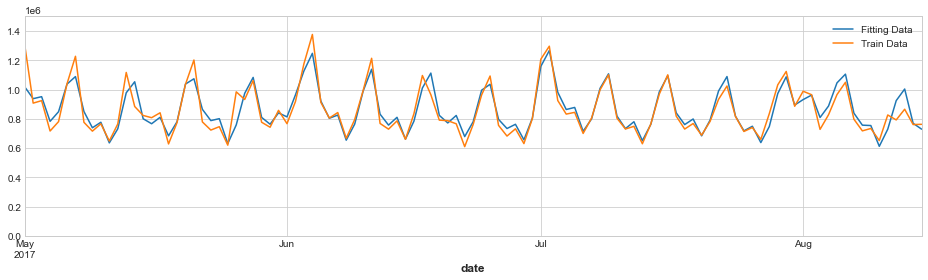

In [24]:
# Creating Seasonality
fourier = CalendarFourier(freq="M", order=4)  # Fourier(period=7, order=3)#
dp = DeterministicProcess(
    index=y_train.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
    period=7,
)
X_1_train = dp.in_sample()
X_1_train = create_date_features(X_1_train)
X_1_train = pd.merge(
    X_1_train, X_dummies, how="left", left_index=True, right_index=True
).fillna(0)

# Create model
"""Different choices:

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

model = BoostedHybrid(
    model_1=Ridge(fit_intercept=False),
    model_2=RandomForestRegressor(n_estimators=200, n_jobs=2),
)
model = BoostedHybrid(
    model_1=Ridge(fit_intercept=False),
    model_2=GradientBoostingRegressor(n_estimators=200),
)
"""

from sklearn.linear_model import Ridge

model = BoostedHybrid(
    model_1=Ridge(fit_intercept=False), model_2=XGBRegressor()
)
model.fit(X_1_train, X_2_train, y_train)
y_pred = model.predict(X_1_train, X_2_train).clip(0)

# Visualizing Training
figsize = (13, 4)
fig, ax = plt.subplots(figsize=figsize)

y_pred.reset_index().groupby("date").sum().sum(axis=1).reset_index().set_index(
    "date"
).plot(ax=ax)
train_data.groupby("date").agg({"sales": "sum"}).reset_index().set_index(
    "date"
).plot(ax=ax)

ax.legend(["Fitting Data", "Train Data"])
ax.set(xlim=[date(2017, 5, 1), date(2017, 8, 15)])
ax.set(ylim=[0, 1.5e6])
plt.show()

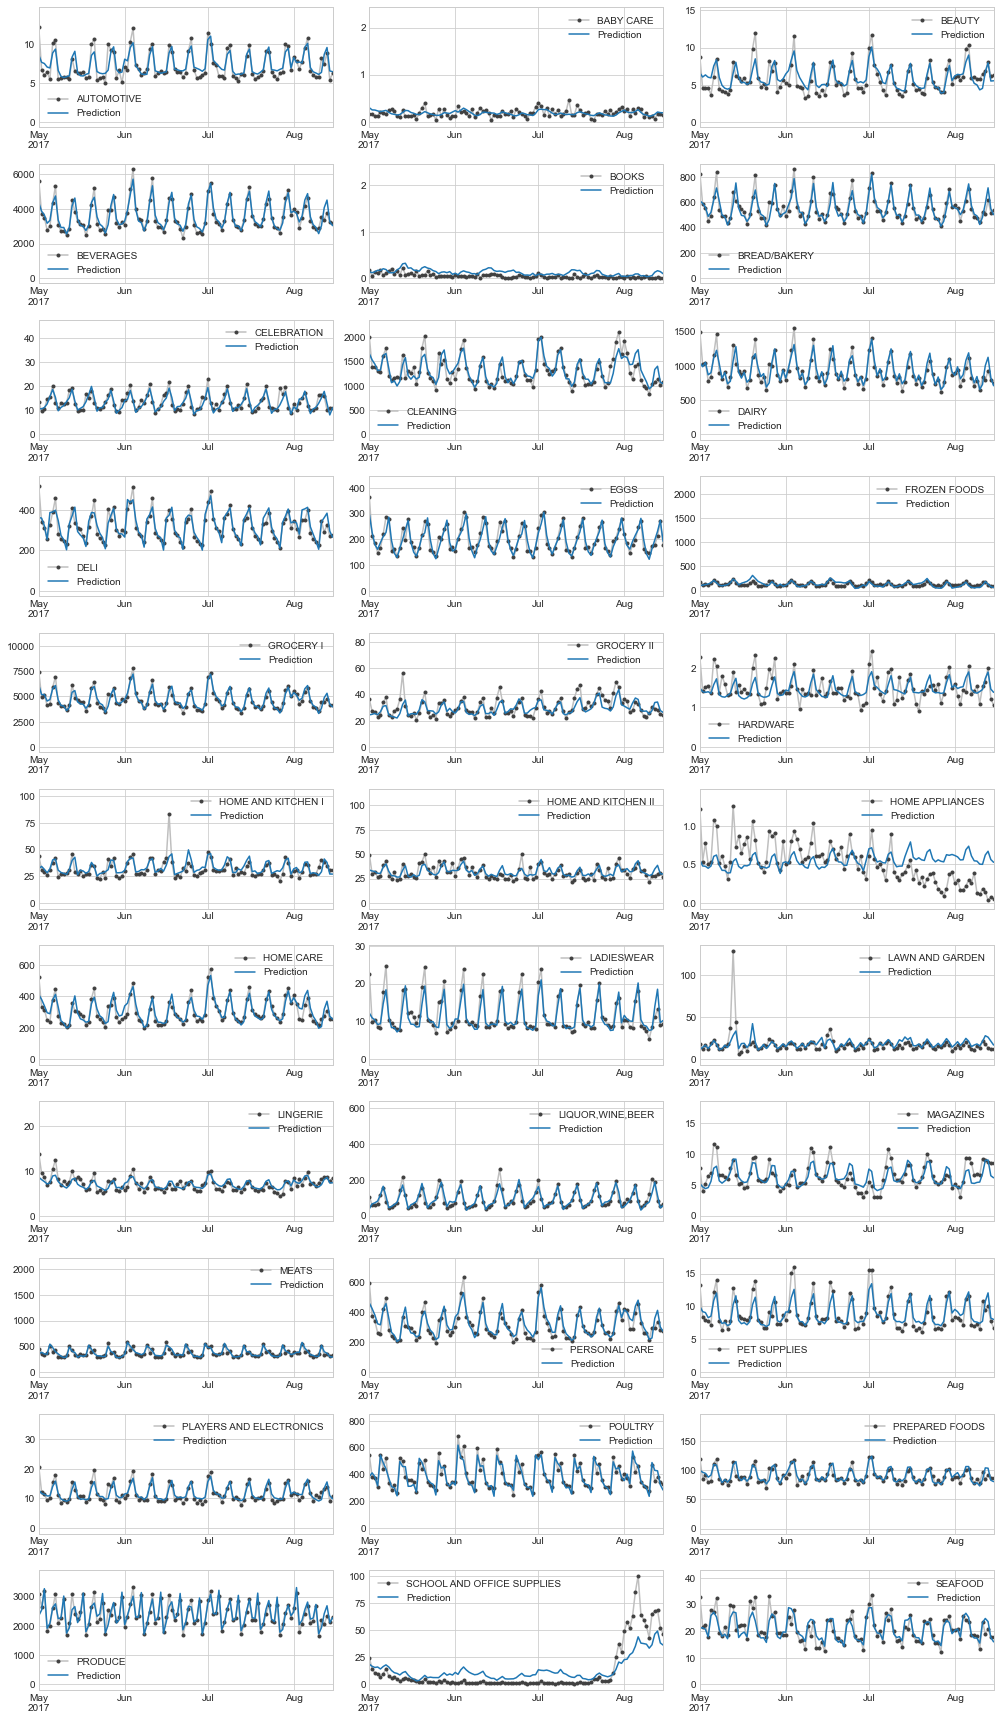

In [25]:
# Visualizing all Family
real = (
    y.unstack()
    .reset_index()
    .rename(columns={0: "sales"})
    .groupby(["date", "family"])
    .agg({"sales": "mean"})
)
pred = (
    y_pred.stack()
    .reset_index()
    .rename(columns={0: "sales"})
    .groupby(["date", "family"])
    .agg({"sales": "mean"})
)

N = len(families)  # Total items
Col = 3  # Number of Columns
Row = N // Col if N % Col == 0 else N // Col + 1
figsize = (14, 2 * 12)
fig, ax = plt.subplots(Row, Col, figsize=figsize)
for i, FAMILY in enumerate(families):
    real.loc[(slice(None), FAMILY), :].reset_index().drop(
        "family", axis=1
    ).set_index("date").plot(**plot_params, ax=ax[(i // Col), i % Col])
    pred.loc[(slice(None), FAMILY), :].reset_index().drop(
        "family", axis=1
    ).set_index("date").plot(ax=ax[(i // Col), i % Col])
    ax[(i // Col), i % Col].set(xlim=[date(2017, 5, 1), date(2017, 8, 15)])
    ax[(i // Col), i % Col].legend([FAMILY, "Prediction"])
    ax[(i // Col), i % Col].set(xlabel="")
for ii in range(i + 1, N):  # if i < N:
    fig.delaxes(ax[(ii // Col), ii % Col])
plt.show()

## Note:

There are high fluctuations where the sales are small so that the patterns (weekly or monthly seasonality) are not visible. Especially, these products are at very low sales:

* BOOKS
* BABY CARE
* SCHOOL AND OFFICE SUPPLIES: mostly 0 during summertime and suddenly jumps at the new academic year. 

Hence, we expect these families to be 0 in the future (when predicting).

# Predict future sales

In [26]:
# Creating Testing Features
X_1_test = dp.out_of_sample(steps=16)
X_1_test.index.name = "date"
X_1_test = create_date_features(X_1_test)
X_1_test = pd.merge(
    X_1_test, X_dummies, how="left", left_index=True, right_index=True
).fillna(0)

# Predicting Testing Data
y_test_pred = model.predict(X_1_test, X_2_test).clip(0)

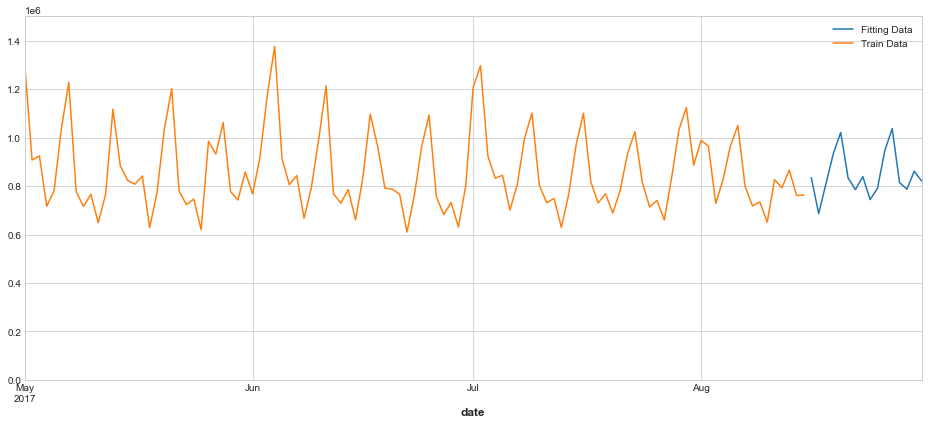

In [27]:
# Visualizing
figsize = (13, 6)
fig, ax = plt.subplots(figsize=figsize)

y_test_pred.reset_index().groupby("date").sum().sum(
    axis=1
).reset_index().set_index("date").plot(ax=ax)
train_data.groupby("date").agg({"sales": "sum"}).reset_index().set_index(
    "date"
).plot(ax=ax)

ax.legend(["Fitting Data", "Train Data"])
ax.set(xlim=[date(2017, 5, 1), date(2017, 8, 31)])
ax.set(ylim=[0, 1.5e6])
plt.show()

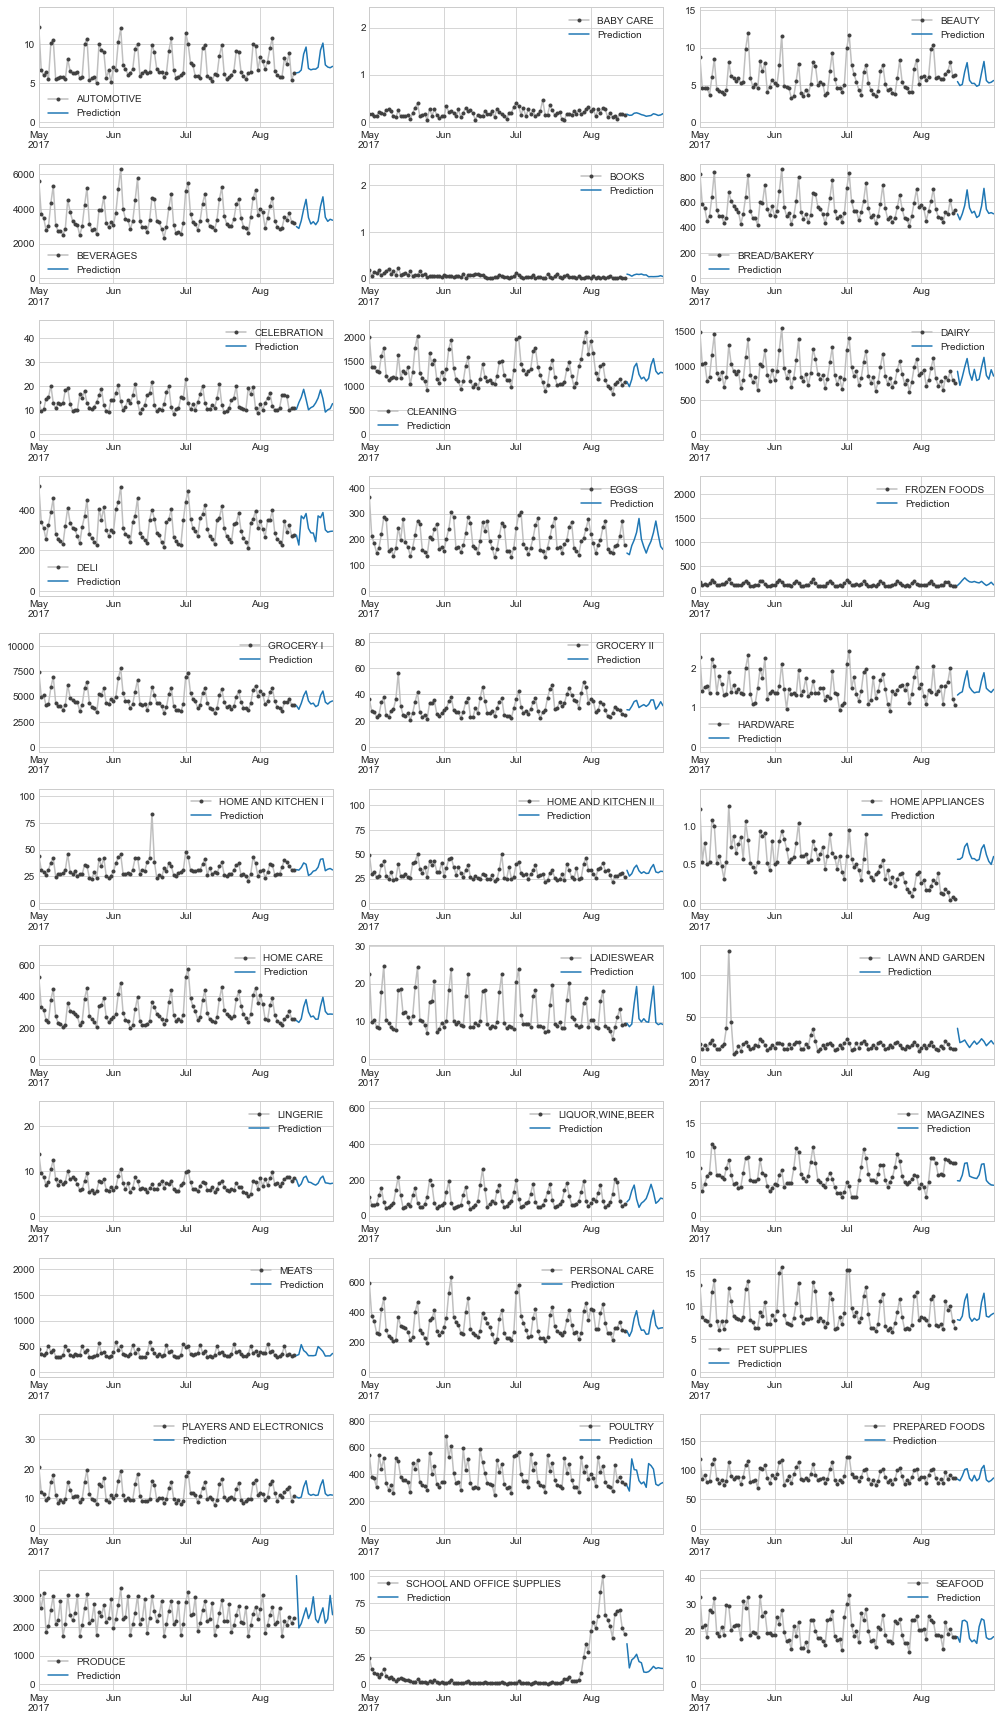

In [28]:
# Visualizing all Family
real = (
    y.unstack()
    .reset_index()
    .rename(columns={0: "sales"})
    .groupby(["date", "family"])
    .agg({"sales": "mean"})
)
pred = (
    y_test_pred.stack()
    .reset_index()
    .rename(columns={0: "sales"})
    .groupby(["date", "family"])
    .agg({"sales": "mean"})
)

N = len(families)  # Total items
Col = 3  # Number of Columns
Row = N // Col if N % Col == 0 else N // Col + 1
figsize = (14, 2 * 12)
fig, ax = plt.subplots(Row, Col, figsize=figsize)
for i, FAMILY in enumerate(families):
    real.loc[(slice(None), FAMILY), :].reset_index().drop(
        "family", axis=1
    ).set_index("date").plot(**plot_params, ax=ax[(i // Col), i % Col])
    pred.loc[(slice(None), FAMILY), :].reset_index().drop(
        "family", axis=1
    ).set_index("date").plot(ax=ax[(i // Col), i % Col])
    ax[(i // Col), i % Col].set(xlim=[date(2017, 5, 1), date(2017, 8, 31)])
    ax[(i // Col), i % Col].legend([FAMILY, "Prediction"])
    ax[(i // Col), i % Col].set(xlabel="")
    
for ii in range(i + 1, N):  # if i < N:
    fig.delaxes(ax[(ii // Col), ii % Col])
plt.show()